# ml lab5

In [7]:
import os

import numpy as np

import scipy.optimize as opt
import scipy.io

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

### 1. read `ex5data1.mat`

In [4]:
data = scipy.io.loadmat('data/ex5data1.mat')
X = data['X']
y = np.squeeze(data['y'])
X.shape, y.size

((51, 2), 51)

### 2. plot data

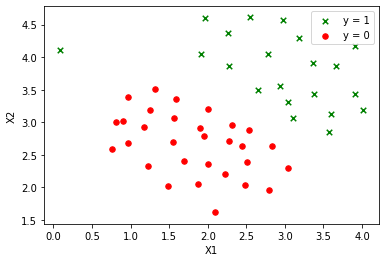

In [25]:
def plot_data(X, y, axes=None):    
    if axes == None:
        axes = plt.gca()
    
    axes.scatter(X[y == 1, 0], X[y == 1, 1], marker='x', c='g', s=30, label='y = 1')
    axes.scatter(X[y == 0, 0], X[y == 0, 1], c='r', s=30, label='y = 0')
    axes.set_xlabel('X1')
    axes.set_ylabel('X2')
    axes.legend(frameon= True, fancybox = True)
    
    return axes
    
plot_data(X, y)

### 3. svm classifier

In [8]:
from sklearn import svm

clf = svm.LinearSVC()
clf.fit(X, y)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

### 4. descision boundary with `c=1`, `c=100`

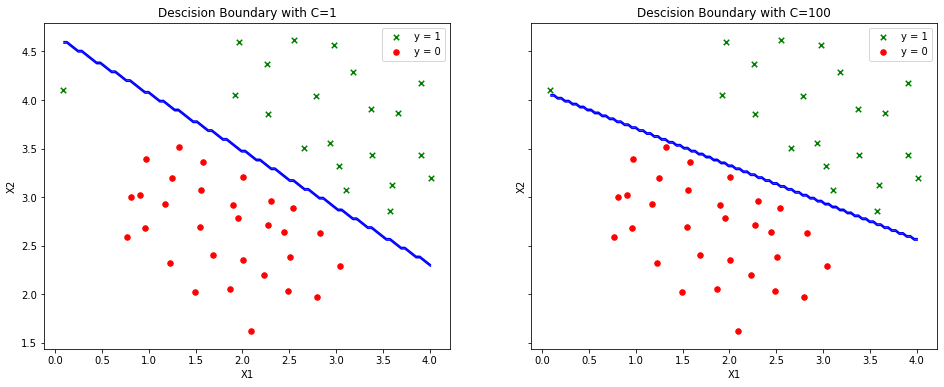

In [23]:
C_VALS = [1, 100]
fig, axes = plt.subplots(1, 2, sharey = True, figsize=(16, 6))

def get_meshgrid(X, num=100):
    return np.meshgrid(
        np.linspace(X[:, 0].min(), X[:, 0].max(), num=100),
        np.linspace(X[:, 1].min(), X[:, 1].max(), num=100)
    )

for i, C in enumerate(C_VALS):
    X_1, X_2 = get_meshgrid(X)
    
    clf = svm.LinearSVC(C=C, max_iter=100000)
    clf.fit(X, y)
    Z = clf.predict(np.array([X_1.ravel(), X_2.ravel()]).T).reshape(X_1.shape)
    
    plot_data(X, y, axes[i])
    axes[i].contour(X_1, X_2, Z, 1, colors='b')
    axes[i].set_title(f'Descision Boundary with C={C}')

> При `C=100` можно наблюдать переобученую модель: граница захватывает случайные выбросы. При `C=1` граница выглядит правильно.

### 5. svm gaussian kernel

In [22]:
def gaussian_kernel(x1, x2, sigma):
    return np.exp(-np.sum((x1 - x2) ** 2) / (2 * (sigma ** 2)))

def gaussian_kernel_gram_matrix(X, L, sigma, K_function=gaussian_kernel):
    gram_matrix = np.zeros((X.shape[0], L.shape[0]))
    for i, x in enumerate(X):
        for j, l in enumerate(L):
            gram_matrix[i, j] = K_function(x, l, sigma)
    return gram_matrix

### 6-8. `ex5data2.mat` with svm gaussian kernel

In [29]:
data = scipy.io.loadmat('data/ex5data2.mat')
X = data['X']
y = np.squeeze(data['y'])

L = X
sigma = 0.1
gram = gaussian_kernel_gram_matrix(X, L, sigma)
clf = svm.SVC(kernel='precomputed')
clf.fit(gram, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='precomputed', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

### 9. plot data

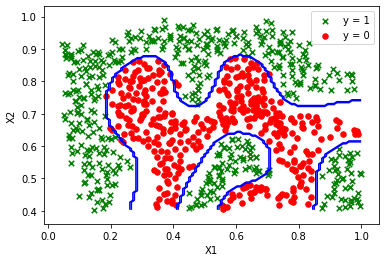

In [30]:
ax = plot_data(X, y)

X_1, X_2 = get_meshgrid(X)
X_plot = np.array([X_1.ravel(), X_2.ravel()]).T
gram_plot = gaussian_kernel_gram_matrix(X_plot, L, sigma)
Z = clf.predict(gram_plot).reshape(X_1.shape)

ax.contour(X_1, X_2, Z, 1, colors='b')

### 10. read `ex5data3` data

In [33]:
data = scipy.io.loadmat('data/ex5data3.mat')
X = data['X']
y = np.squeeze(data['y'])
X_val = data['Xval']
y_val = np.squeeze(data['yval'])

X.shape, X_val.shape

((211, 2), (200, 2))

### 11. cross validation

In [34]:
def cross_validate(X, y, X_val, y_val):
    C_array = np.array([0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30])
    sigma_array = np.array([0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30])
    err_array = np.zeros([C_array.size, sigma_array.size])
    
    for i in np.arange(C_array.size):
        for j in np.arange(sigma_array.size):
            sigma = sigma_array[j]
            C = C_array[i]
            
            gram = gaussian_kernel_gram_matrix(X, X, sigma)
            clf = svm.SVC(C=C, kernel='precomputed')
            clf.fit(gram, y)
            
            predictions = clf.predict(gaussian_kernel_gram_matrix(X_val, X, sigma))
            pred_error = np.mean(predictions != y_val)

            err_array[i, j] = pred_error

    idx = np.unravel_index(np.argmin(err_array, axis=None), err_array.shape)
    C = C_array[idx[0]]
    sigma = sigma_array[idx[1]]
    
    return C, sigma

In [35]:
C, sigma = cross_validate(X, y, X_val, y_val)
print(f'Found:\nC:\t{C}\nsigma:\t{sigma}')

Found:
C:	1.0
sigma:	0.1


In [36]:
gram = gaussian_kernel_gram_matrix(X, X, sigma)
clf = svm.SVC(C=C, kernel='precomputed')
clf.fit(gram, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='precomputed', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

### 12. plot data

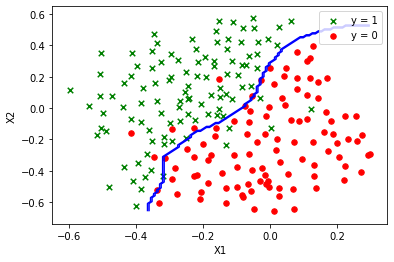

In [37]:
ax = plot_data(X, y)

X_1, X_2 = get_meshgrid(X, num=50)
X_plot = np.array([X_1.ravel(), X_2.ravel()]).T
gram_plot = gaussian_kernel_gram_matrix(X_plot, X, sigma)
Z = clf.predict(gram_plot).reshape(X_1.shape)

ax.contour(X_1, X_2, Z, 1, colors='b')

### 13-15. read `spamTrain.mat` & `spamTest.mat` data

In [38]:
spam_train = scipy.io.loadmat('data/spamTrain.mat')
X = spam_train['X']
y = np.squeeze(spam_train['y'])

spam_test = scipy.io.loadmat('data/spamTest.mat')
X_test = spam_test['Xtest']
y_test = np.squeeze(spam_test['ytest'])

### 14-16. svm + cross validation

In [39]:
def spam_cross_validation(X, y, X_val, y_val):
    C_array = np.array([0.01, 0.1, 0.3, 1, 10])
    err_array = np.zeros(C_array.size)

    for i in np.arange(C_array.size):
        C = C_array[i]
        
        clf = svm.SVC(C=C, kernel='linear')
        clf.fit(X, y)
        
        predictions = clf.predict(X_val)
        pred_error = np.mean(predictions != y_val)

        err_array[i] = pred_error

    idx = np.unravel_index(np.argmin(err_array, axis=None), err_array.shape)
    return C_array[idx[0]]

In [40]:
C = spam_cross_validation(X, y, X_test, y_test)
print(f'Found:\nC:\t{C}\n')

Found:
C:	0.1



In [42]:
clf = svm.SVC(C=C, kernel='linear')
clf.fit(X, y)

train_accuracy = clf.score(X, y) * 100
test_accuracy = clf.score(X_test, y_test) * 100

print(f'Train accuracy:\t{train_accuracy}%')
print(f'Test accuracy:\t{test_accuracy}%')

Train accuracy:	99.825%
Test accuracy:	98.9%


> Линейное ядро быстрее и точнее чем Гаусовское

### 17. text preprocessing

In [44]:
import re
from nltk.stem import PorterStemmer

ps = PorterStemmer()
HTML_REGEX = r'<.*?>'
URL_REGEX = r'[http|https]://[^\s]*'
EMAIL_REGEX = r'[^\s]+@[^\s]+'
NUMBER_REGEX = r'[0-9]+'
DOLLAR_REGEX = r'[$]+'

def preprocess_data(data):
    result = data.lower()
    result = re.sub(HTML_REGEX, '', result)
    result = re.sub(URL_REGEX, 'httpaddr', result)
    result = re.sub(EMAIL_REGEX, 'emailaddr', result)
    result = re.sub(NUMBER_REGEX, ' number ', result)
    result = re.sub(DOLLAR_REGEX, ' dollar ', result)
    result = re.sub(r'[^a-zA-Z\s]+', ' ', result)
    result = result.replace('\n', ' ')
    result = [ps.stem(token) for token in result.split(' ')]
    result = ' '.join(result)
    return result

### 18. read `vocab.txt`

In [45]:
vocab_data = open('data/vocab.txt', 'r').read().split('\n')[:-1]
vocab = {}
for elem in vocab_data:
    index, word = elem.split('\t')[:]
    vocab[word] = index

### 19. word to code

In [46]:
def map_to_vocabulary(data, vocab):
    result = []
    for word in data.split():
        if len(word) > 1 and word in vocab:
            result.append(int(vocab[word]))

    return result

### 20. text to feature vector

In [47]:
def map_to_feature(data, vocab):
    n = len(vocab)
    features = np.zeros((n,))
    for i in data:
        features[i] = 1

    return features

In [50]:
def generate_feature(data, vocab):
    preprocessed = preprocess_data(data)
    word_indexes = map_to_vocabulary(preprocessed, vocab)
    feature = map_to_feature(word_indexes, vocab)
    
    return feature

### 21. test classifier

In [53]:
def predict_from_files(files, vocab, clf):
    features = []
    for file in files:
        feature = generate_feature(open(f'data/{file}', 'r').read(), vocab)
        features.append(feature)

    features = np.array(features)
    result = clf.predict(features)
    return zip(files, result)

In [54]:
FILES = ['emailSample1.txt', 'emailSample2.txt', 'spamSample1.txt', 'spamSample2.txt']
predicts = predict_from_files(FILES, vocab, clf)

for file, predict in predicts:
    res = 'spam' if predict == 1 else 'not spam'
    print(f'{file} - {res}')

emailSample1.txt - not spam
emailSample2.txt - not spam
spamSample1.txt - spam
spamSample2.txt - spam


### 22. get dataset from [`spamassassin.apache.org/old/publiccorpus`](http://spamassassin.apache.org/old/publiccorpus/)

In [67]:
HAM_DIR = 'data/easy_ham'
SPAM_DIR = 'data/spam'

def read_data(data_dir, out):
    files = os.listdir(data_dir)
    for file_name in files:
        if file_name == '.DS_Store':
            continue
        with open(f'{data_dir}/{file_name}', 'r') as f:
            try:
                out.append(f.read())
            except:
                continue
    return out

X_data = []
X_data = read_data(HAM_DIR, X_data)
y_ham = np.zeros(len(X_data))

X_data = read_data(SPAM_DIR, X_data)
y_spam = np.ones(len(X_data) - len(y_ham))
y = np.concatenate((y_ham, y_spam))

len(X_data), y.size

(2827, 2827)

### 24. build vocabulary

In [68]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import  train_test_split

X_vocab = []
for data in X_data[100:]:
    X_vocab.append(preprocess_data(data))

vectorizer = CountVectorizer()
vectorizer.fit(X_vocab)
n = 1000
vocab = {}
index = 0
for word in vectorizer.vocabulary_:
    vocab[word] = index
    index += 1
    if index >= n:
        break

### 25. test new dataset

In [69]:
X = []
for data in X_data:
    feature = generate_feature(data, vocab)
    X.append(feature)

X = np.array(X)

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [71]:
C = 0.1
clf = svm.SVC(C=C, kernel='linear')
clf.fit(X_train, y_train)

train_accuracy = clf.score(X, y) * 100
test_accuracy = clf.score(X_test, y_test) * 100

print(f'Train accuracy:\t{train_accuracy}%')
print(f'Test accuracy:\t{test_accuracy}%')

Train accuracy:	100.0%
Test accuracy:	100.0%


In [73]:
FILES = ['emailSample1.txt', 'emailSample2.txt', 'spamSample1.txt', 'spamSample2.txt']
predicts = predict_from_files(FILES, vocab, clf)

for file, predict in predicts:
    res = 'spam' if predict == 1 else 'not spam'
    print(f'{file} - {res}')

emailSample1.txt - not spam
emailSample2.txt - not spam
spamSample1.txt - spam
spamSample2.txt - spam


> Качество классификации сохранилось, тк новый датасет достаточно большой, что позволяет произвести обучение

### 26. conclusions

Был рассмотрен метод опорных векторов, обучен класификатор с разными ядрами, подобраны параметры C и σ2. Протестирован анализатор спама в сообщениях как на готовом наборе признаков, так и на собственном словаре